In [1]:
import warnings 
warnings.filterwarnings('ignore') # feel free to comment this out if you want to see warnings 

import csv 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Flatten


from statsmodels.tools.eval_measures import rmse

import numpy as np


Using TensorFlow backend.


In [2]:
mers = pd.read_csv('../data/mers-outbreak-dataset-20122019/weekly_clean.csv')


In [3]:
mers.head(15)

,Year,Week,Region,New Cases
0,2012,12,Other Countries,1
1,2012,12,Republic of Korea,0
2,2012,12,Saudi Arabia,0
3,2012,13,Other Countries,0
4,2012,13,Republic of Korea,0
5,2012,13,Saudi Arabia,0
6,2012,14,Other Countries,1
7,2012,14,Republic of Korea,0
8,2012,14,Saudi Arabia,0
9,2012,15,Other Countries,0


What countries were impacted with mers? 

In [4]:
countries = list(mers["Region"].unique())
countries

['Other Countries', 'Republic of Korea', 'Saudi Arabia']

In [5]:
other = mers.loc[mers["Region"] == "Other Countries"]
other = other.reset_index(drop=True)

korea = mers.loc[mers["Region"] == "Republic of Korea"]
korea = korea.reset_index(drop=True)

sa = mers.loc[mers["Region"] == "Saudi Arabia"]
sa = sa.reset_index(drop=True)

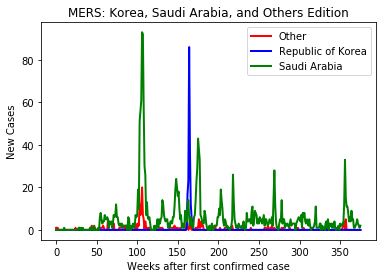

In [6]:
plt.plot(other.index, other['New Cases'], 'r', linewidth = 2, label="Other")
plt.plot(korea.index, korea['New Cases'],'b',linewidth = 2, label="Republic of Korea")
plt.plot(sa.index, sa['New Cases'],'g',linewidth = 2, label="Saudi Arabia")
plt.title("MERS: Korea, Saudi Arabia, and Others Edition")
plt.xlabel("Weeks after first confirmed case")
plt.ylabel("New Cases")
plt.legend()
plt.show()

In [7]:
sa.Year = pd.to_datetime(sa.Year.astype(str), format='%Y') + \
             pd.to_timedelta(sa.Week.mul(7).astype(str) + ' days')
             
korea.Year = pd.to_datetime(korea.Year.astype(str), format='%Y') + \
             pd.to_timedelta(korea.Week.mul(7).astype(str) + ' days')

other.Year = pd.to_datetime(other.Year.astype(str), format='%Y') + \
             pd.to_timedelta(other.Week.mul(7).astype(str) + ' days')
             

sa = sa.drop(["Week"],axis=1)
korea = korea.drop(["Week"],axis=1)
other = other.drop(["Week"],axis=1)

sa = sa.drop(["Region"],axis=1)
korea = korea.drop(["Region"],axis=1)
other = other.drop(["Region"],axis=1)

sa = sa.set_index("Year")
korea = korea.set_index("Year")
other = other.set_index("Year")


train_data_sa = sa[:len(sa)-75]
test_data_sa = sa[len(sa)-75:]
train_data_korea = korea[:len(korea)-75]
test_data_korea = korea[len(korea)-75:]
train_data_other = other[:len(other)-75]
test_data_other = other[len(other)-75:]


In [8]:
scaler = MinMaxScaler()
scaler.fit(train_data_sa)
scaled_train_data = scaler.transform(train_data_sa)
scaled_test_data = scaler.transform(test_data_sa)

n_input = 7
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)


lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

lstm_model.fit_generator(generator,epochs=20)


Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
294/294 [==============================] - 2s 7ms/step - loss: 0.0108
Epoch 2/20
294/294 [==============================] - 2s 6ms/step - loss: 0.0090
Epoch 3/20
294/294 [==============================] - 2s 5ms/step - loss: 0.0071
Epoch 4/20
294/294 [==============================] - 2s 5ms/step - loss: 0.0057
Epoch 5/20
294/294 [==============================] - 2s 5ms/step 

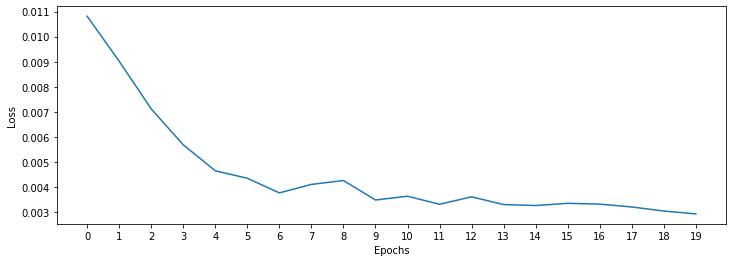

In [9]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);




In [10]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data_sa)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions_scaled

[array([0.04486926], dtype=float32),
 array([0.03295872], dtype=float32),
 array([0.02218858], dtype=float32),
 array([0.01506613], dtype=float32),
 array([0.01095298], dtype=float32),
 array([0.00904561], dtype=float32),
 array([0.0086201], dtype=float32),
 array([0.0090995], dtype=float32),
 array([0.01023673], dtype=float32),
 array([0.01155613], dtype=float32),
 array([0.01275164], dtype=float32),
 array([0.01381348], dtype=float32),
 array([0.01458922], dtype=float32),
 array([0.01503975], dtype=float32),
 array([0.01520175], dtype=float32),
 array([0.01514398], dtype=float32),
 array([0.01494537], dtype=float32),
 array([0.01467388], dtype=float32),
 array([0.01439285], dtype=float32),
 array([0.01414811], dtype=float32),
 array([0.01397259], dtype=float32),
 array([0.01386764], dtype=float32),
 array([0.01382183], dtype=float32),
 array([0.01382202], dtype=float32),
 array([0.01385297], dtype=float32),
 array([0.01390045], dtype=float32),
 array([0.01395403], dtype=float32),
 ar

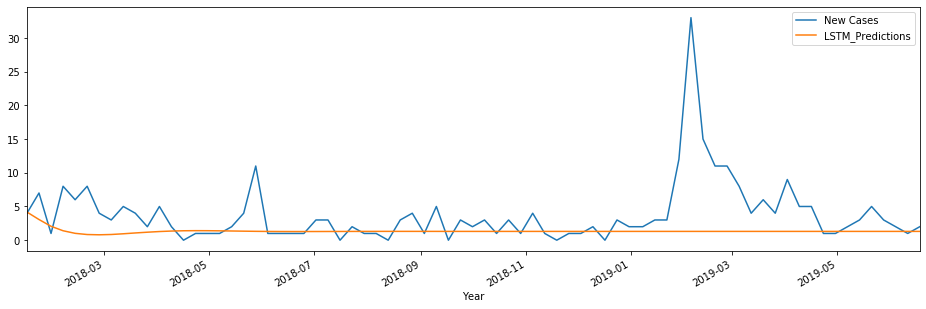

In [11]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

lstm_predictions

test_data_sa['LSTM_Predictions'] = lstm_predictions
test_data_sa


test_data_sa['New Cases'].plot(figsize = (16,5), legend=True)
test_data_sa['LSTM_Predictions'].plot(legend = True);


In [12]:
lstm_rmse_error_sa = rmse(test_data_sa['New Cases'], test_data_sa["LSTM_Predictions"])
lstm_mse_error_sa = lstm_rmse_error_sa**2
mean_value = sa['New Cases'].mean()

In [13]:
scaler = MinMaxScaler()
scaler.fit(train_data_korea)
scaled_train_data = scaler.transform(train_data_korea)
scaled_test_data = scaler.transform(test_data_korea)

n_input = 7
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)


lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

lstm_model.fit_generator(generator,epochs=20)



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
294/294 [==============================] - 2s 6ms/step - loss: 0.0042
Epoch 2/20
294/294 [==============================] - 1s 5ms/step - loss: 0.0040
Epoch 3/20
294/294 [==============================] - 1s 5ms/step - loss: 0.0037
Epoch 4/20
294/294 [==============================] - ETA: 0s - loss: 0.003 - 1s 5ms/step - loss: 0.0035
Epoch 5/20
294/294 [==============================] - 1s 5ms/step - loss: 0.0032
Epoch 6/20
294/294 [==============================] - 1s 5ms/step - loss: 0.0033


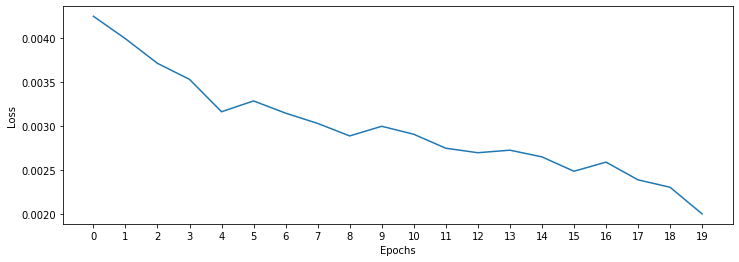

In [14]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);




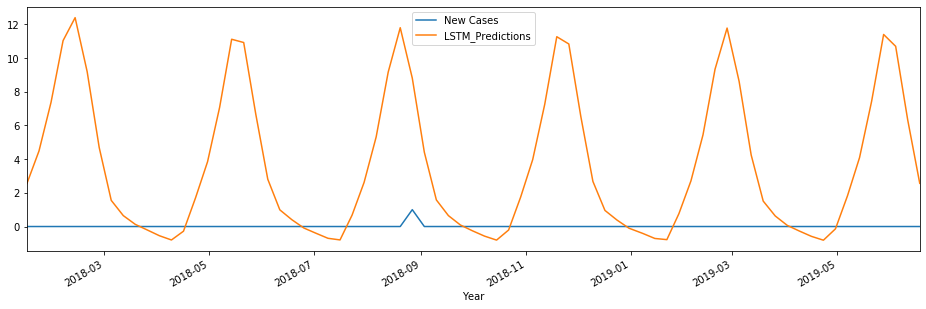

In [15]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data_korea)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions_scaled

lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

lstm_predictions

test_data_korea['LSTM_Predictions'] = lstm_predictions
test_data_korea


test_data_korea['New Cases'].plot(figsize = (16,5), legend=True)
test_data_korea['LSTM_Predictions'].plot(legend = True);

In [16]:

lstm_rmse_error_korea = rmse(test_data_korea['New Cases'], test_data_korea["LSTM_Predictions"])
lstm_mse_error_korea = lstm_rmse_error_korea**2
mean_value = korea['New Cases'].mean()

In [17]:
scaler = MinMaxScaler()
scaler.fit(train_data_other)
scaled_train_data = scaler.transform(train_data_other)
scaled_test_data = scaler.transform(test_data_other)



 

n_input = 7
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)


lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

lstm_model.fit_generator(generator,epochs=20)




Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
294/294 [==============================] - 2s 6ms/step - loss: 0.0073
Epoch 2/20
294/294 [==============================] - 2s 5ms/step - loss: 0.0067
Epoch 3/20
294/294 [==============================] - 1s 5ms/step - loss: 0.0062
Epoch 4/20
294/294 [==============================] - 1s 5ms/step - loss: 0.0059
Epoch 5/20
294/294 [==============================] - 1s 5ms/step - loss: 0.0058
Epoch 6/20
294/294 [==============================] - 1s 5ms/step - loss: 0.0054
Epoch 7/20
294/294 [====

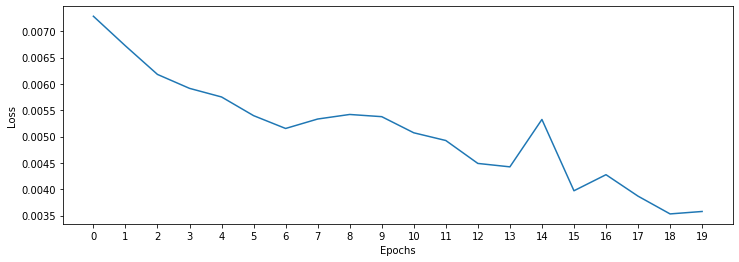

In [18]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);




In [19]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data_other)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

lstm_predictions_scaled

lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

lstm_predictions




array([[0.25714379],
       [0.25870577],
       [0.2687373 ],
       [0.25529917],
       [0.26445676],
       [0.24914831],
       [0.25052223],
       [0.25248706],
       [0.25241937],
       [0.25236502],
       [0.25223628],
       [0.25223054],
       [0.25210608],
       [0.25212366],
       [0.2521361 ],
       [0.25213242],
       [0.25212973],
       [0.25212772],
       [0.25212675],
       [0.25212556],
       [0.25212564],
       [0.2521256 ],
       [0.25212549],
       [0.25212534],
       [0.25212534],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.25212526],
       [0.252

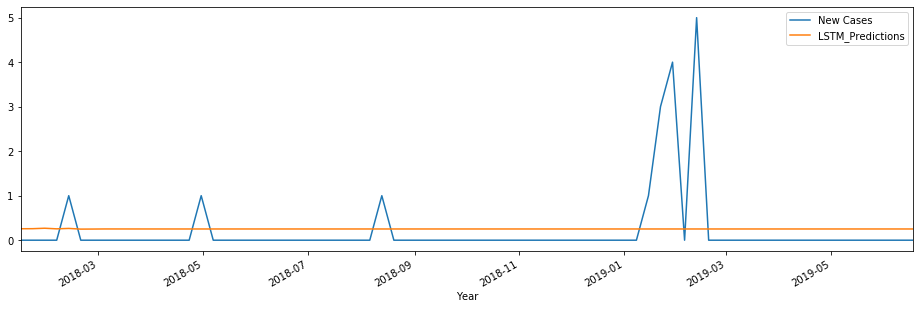

In [20]:
test_data_other['LSTM_Predictions'] = lstm_predictions
test_data_other


test_data_other['New Cases'].plot(figsize = (16,5), legend=True)
test_data_other['LSTM_Predictions'].plot(legend = True);

In [21]:
lstm_rmse_error_other = rmse(test_data_other['New Cases'], test_data_other["LSTM_Predictions"])
lstm_mse_error_other = lstm_rmse_error_other**2
mean_value = other['New Cases'].mean()

In [22]:
from tabulate import tabulate

print(tabulate([
    ['Korea LSTM Errors', lstm_mse_error_korea, lstm_rmse_error_korea], 
    ['Saudi Arabia LSTM Errors', lstm_mse_error_sa, lstm_rmse_error_sa],
    ['Other LSTM Errors', lstm_mse_error_other, lstm_rmse_error_other]], 
    
    headers=['Model', 'MSE', "RMSE", "Mean"]))




Model                           MSE      RMSE
------------------------  ---------  --------
Korea LSTM Errors         30.243     5.49937
Saudi Arabia LSTM Errors  27.2556    5.22069
Other LSTM Errors          0.675942  0.822157
